# Лабораторная работа №1  
## Выполнил студент группы 9382     
## Иерусалимов Никита


### Цель работы
Изучить возможности библиотек Python для решения задач цифровой
обработки сигналов.

### Задачи лабораторной работы 

 1) Освоить Jupyter Notebook.  
 2) Выполнить загрузку аудио сигнала и построить огибающую (график).  
3) Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.  
4) Детектор сигнал/шум. Получить сигнал после детектирования  
5) Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.  
6) Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.  

Загружаем наш со звуком

In [21]:
from scipy.io import  wavfile
from scipy import signal
import scipy.io

import numpy as np
import IPython.display as ipd

frequency, x = wavfile.read('./03-01-05-02-01-02-06_A6.wav') 

/tmp/ipykernel_567674/1091719002.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  frequency, x = wavfile.read('./03-01-05-02-01-02-06_A6.wav')


In [6]:
def showPlot():
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")
    plt.show()

### Построение огибающей кривой
Имеется сигнал $x(i), i = 0,1,...,N-1$. Хотим построить огибающую $y(j), j = 0,1,...,n-1$. Пусть $m = \left[ \frac{N} n \right] $ - число точек в интервале усреднения. Тогда $y(i) = \frac{1} m \displaystyle\sum^{mj+m-1}_{k=mj} |x(k)| $

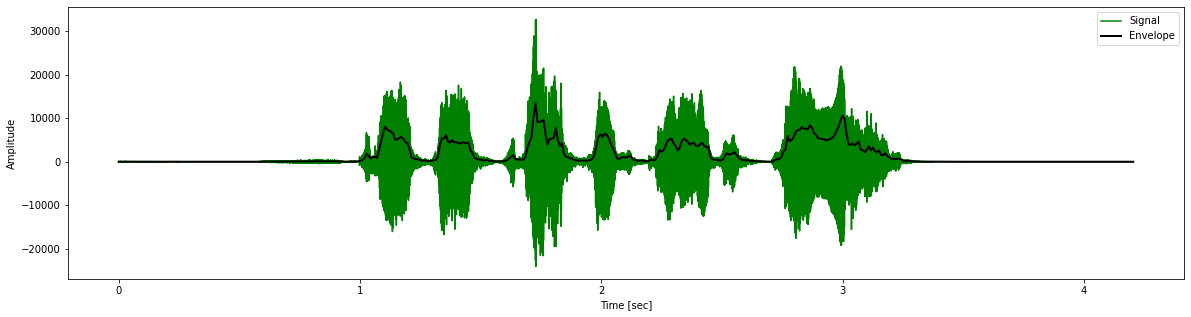

In [16]:
import matplotlib.pyplot as plt
import numpy as np

n = 500

# делим количество точек на частатоу(количество периодов в секунду) получаем продолжительность
duratation = x.size/ frequency
time =  np.linspace(0, duratation, x.size)

m = int(x.size/n)

envelopeTime = np.linspace(0, duratation, n)
envelopeData = []

######## По формуле считаем точки для кривой ############
for j in range(n): 
    s = 0
    for k in range(m * j,m * j + m - 1):s += abs(x[k])
    envelopeData.append(s/m)

#Рисуем график
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(time, x, label="Signal",color="green")
plt.plot(envelopeTime, envelopeData, label="Envelope", linewidth=2,color="black")
plt.legend()
showPlot()





### Фильтрация сигнала 
Надо было выбрать один из 4 фильтров:  
1)Фильтр нижних частот  
2)Фильтр верних частот  
3)Полосовой фильтр  
4)Режекторный Фильтр  

Был выбран фильтр нижних частот.  
Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$, порядок фильтра - $m$. Тогда вычисляем $wn = 2\frac{F_{s}} {F_{d}}$

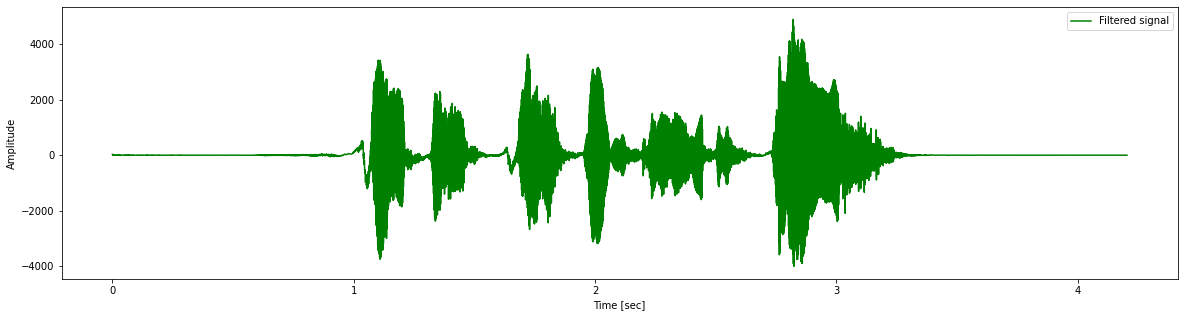

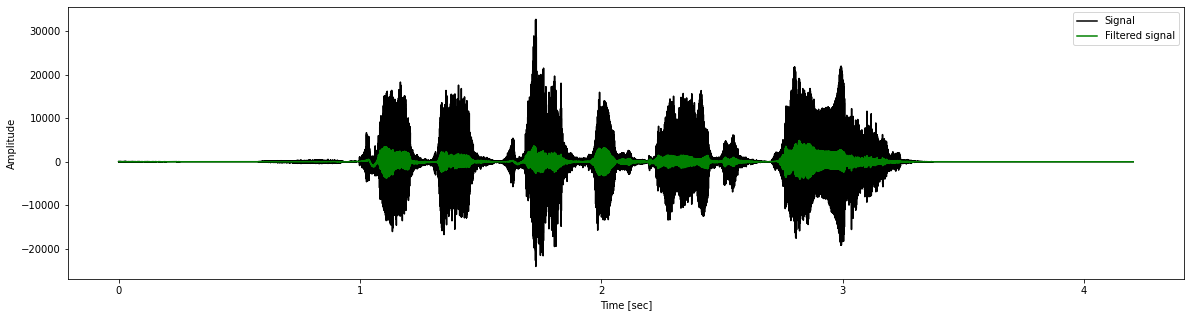

In [8]:

F_s = 400
F_d = frequency

wn = 2 * F_s / F_d
m = 1

b, a = signal.butter(m, wn, 'lowpass')
Filtered = signal.filtfilt(b, a, x)

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(time, Filtered, label="Filtered signal",color="green")
plt.legend()
showPlot()

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(time, x, label="Signal",color="black")
plt.plot(time, Filtered, label="Filtered signal",color="green")
plt.legend()
showPlot()

Сохраним фильтрованный сигнал 

In [22]:
Filtered = Filtered.astype(np.int16)
wavfile.write("LowPass.wav", frequency, Filtered)
ipd.Audio('./LowPass.wav')

### Детектор сигнал/шум 
Определяем среднее сигнала по амплитуде (без учета знака): $mid = \frac{1} N \displaystyle\sum^{N-1}_{k=0}|x(k)|$ 

Определяем порог детектора - $Th = \alpha * mid$, где $0 < \alpha < 1$ подбирается экспериментально. Порог детектора - это некоторая частота, рассчитаная на основе средней, отклонение от которой и будед регестрировать детектор. Задаем величину ”провала”(в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после детектирования. 

$\cdot$ Событие ”начало сигнала”. Если $x(i)$ в течении $k$ отсчетов превышает порог, $y(i) = x(i)$. Порог преодолен  
$\cdot$ Событие ”окончание сигнала”. Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$. Порог не достигнут

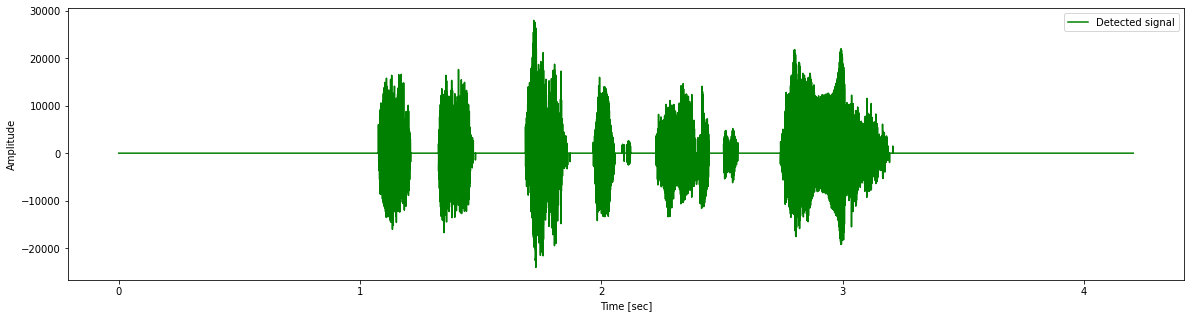

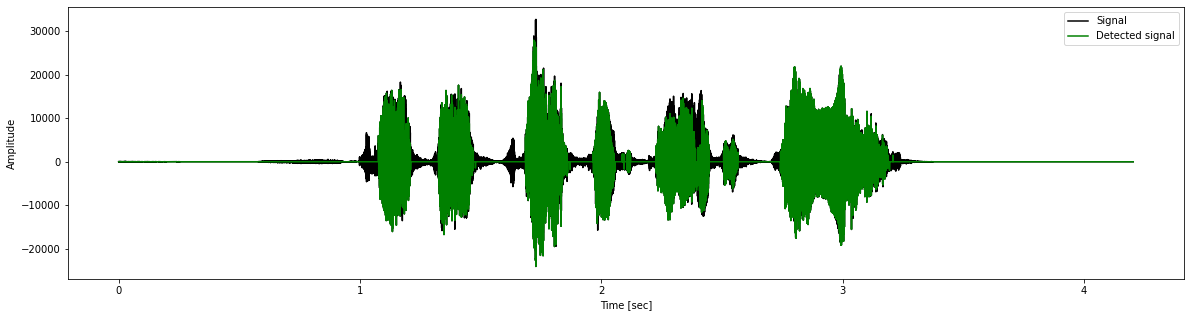

In [10]:
mid = 0
# определяем порог детектора
for k in range(x.size):
  mid += abs(x[k])

mid = mid / x.size

alpha = 0.9
Th = alpha * mid

k = 10
y = np.zeros(x.size)


surpassed = 0

# детектируем события начала и окончания сигнала
for ind in range(x.size):
  if abs(x[ind]) > Th:
    surpassed += 1
    if surpassed >= k:
        y[ind] = x[ind]
  else:
    surpassed = 0


f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(time, y, label="Detected signal",color="green")
plt.legend()
showPlot()

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.plot(time, x, label="Signal",color="black")
plt.plot(time, y, label="Detected signal",color="green")
plt.legend()
showPlot()

Результат обработки

In [24]:
y = y.astype(np.int16)
wavfile.write("detector.wav", frequency, y)
ipd.Audio('./detector.wav')

### Эффект ”Эхо”

Ревербератор реализован, как набор линий задержки. Число линий задержки $N_{L} > 8$. Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): $\alpha_{1} > \alpha_{2} > \dots >\alpha_{N_{L}}$. 

 Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.Желаемое соотношение между ”сухим”и обработанным сигналом задается коэффициентом применимости $\gamma$.Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка $D_1$ , а величины остальных определяются автоматически через нее: $D_i = D_1 2 \frac{1-i} {N_L}, i = 2, \dots,N_L$.  
Для готовой конфигурации пользователь вручную задает последовательность $D_1 > D_2 > \dots > D_{N_L}$. 

In [164]:

def reverberationFunc(maxDelay):
    gamma = 0.9 # сила наложенного эхо
    N_l = 15
    D = [0 for i in range(N_l)]
    a = [0 for i in range(N_l)]
    D[0] = maxDelay
    a[0] = 1

    F_s = 600 
    wn = 2 * F_s / frequency
    
    fragments = []
    
    for i in range(1,N_l):
        D[i] = round(D[i - 1] / 2)
        a[i] = a[i - 1] / 2
    
   

    for i in range(N_l):
        frag = [0 for i in range(D[i])]
        frag.extend(x)
        fragments.append([frag[j]*a[i] for j in range(len(frag))])

    reverberation = fragments[0]
    for i in range(1, N_l):
        for j in range(len(fragments[i])): reverberation[j] += fragments[i][j]
        
    

    b,a = signal.butter(m, wn, btype = 'lowpass')
    filted_reverberation = signal.filtfilt(b,a, reverberation)    

    for i in range(len(filted_reverberation)): filted_reverberation[i] *= gamma
    for i in range(len(x)): filted_reverberation[i] += x[i]

    return filted_reverberation
    
f1 = reverberationFunc(100000)
f2 = reverberationFunc(10000)


In [152]:
f1 = np.array(f1).astype(np.int16)
wavfile.write("echo1.wav",frequency, f1)
ipd.Audio('./echo1.wav')

In [150]:
f2 = np.array(f2).astype(np.int16)
wavfile.write("echo2.wav",frequency, f2)
ipd.Audio('./echo2.wav')


## Эффект ”Distortion” (дополнительно)

Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i) i = 0,1, \dots,N − 1$. Пользователь задает порог — $Th$ и максимальное значение
сигнала $Max > Th$. Тогда $Y(i) = 
 \begin{cases} x(i), |x(i)| \leq Th, \\ Max * sign(x(i)), |x(i)| > Th
 \end{cases}
$

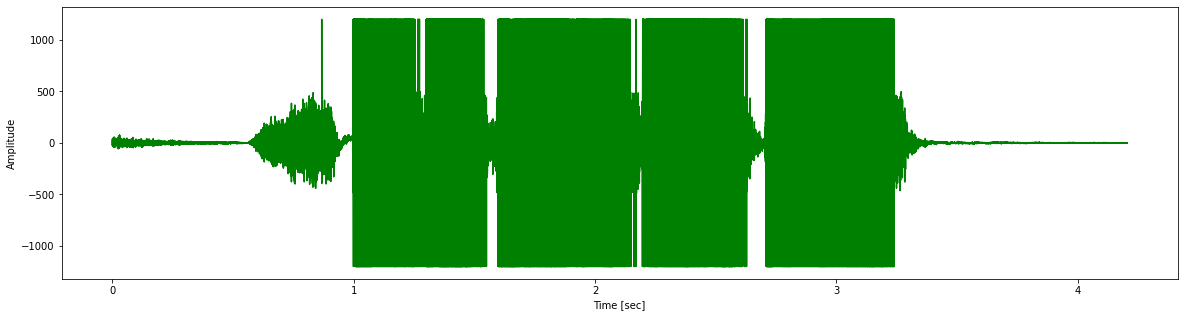

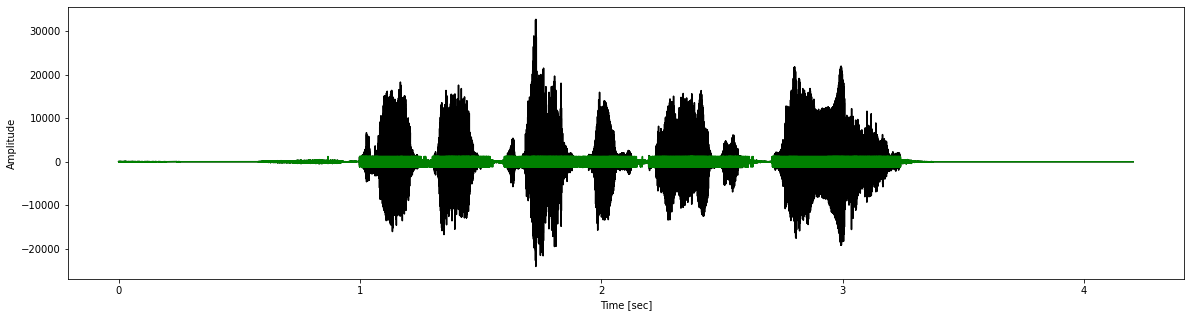

In [161]:
Th = 500
Max = 1200

distortionArr = []
for i in range(len(x)):
    if abs(x[i]) <= Th:
        distortionArr.append(x[i])
    else:
        distortionArr.append(Max * np.sign(x[i]))

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(time, distortionArr, color="green")
showPlot()

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(time, x, label="Signal",color="black")
plt.plot(time, distortionArr, color="green")
showPlot()

In [162]:
distortion = np.array(arr).astype(np.int16)
wavfile.write("distortion.wav",frequency, distortion)
ipd.Audio('./distortion.wav')

### **Выводы по лабораторной работе**

Были получены навыки работы с Jupyter Notebook, а также с библиотеками языка python - matplotlib, numpy, scipy, были получены навыки обработки и визуализации звуковых сигналов

С помощью этих библиотек были созданы и опробованы на звуковом файле несколько типов фильтров.